<a href="https://colab.research.google.com/github/ChagataiDuru/CS304-IntroAI-CollabNotebooks/blob/main/CS304_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2


In [1]:
# Importing Necessary Libraries and File for Part 2 soft-margin SVM to handwritten digits
from os.path import exists
import itertools as itertools

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from google.colab import drive
drive.mount('/content/drive')

train_data = "/content/drive/MyDrive/Colab Notebooks/CS304/HW2/features_train.txt"
test_data = "/content/drive/MyDrive/Colab Notebooks/CS304/HW2/features_test.txt"

# - Supress all warnings (Optional)
import warnings
warnings.simplefilter(action='ignore',
                      category=FutureWarning)
if exists(train_data) and exists(test_data):
    print(f"\nBoth {train_data} and {test_data} exists.")
else:
    print("Please set directory to read the files")



Mounted at /content/drive

Both /content/drive/MyDrive/Colab Notebooks/CS304/HW2/features_train.txt and /content/drive/MyDrive/Colab Notebooks/CS304/HW2/features_test.txt exists.


# Part 1

Consider the nonlinear error surface $E(u, v)=\left(u e^{v}-2 v e^{-u}\right)^{2}$. We start at the point $$(u, v)=(1,1)$$ and minimize this error using gradient descent in the $u v$ space. Use $$\eta=0.1$$ (learning rate, not step size).
## Question 1 ##
What is the partial derivative of $E(u, v)$ with respect to $u$, i.e., $\frac{\partial E}{\partial u}$ ?

**Answer:**

**Error Surface:**

$$E(u, v) = \left(u e^{v}-2 v e^{-u}\right)^{2}$$

**Partial Derivative with Respect to u:**

$$\frac{\partial E}{\partial u} = 2\left(e^{v}+2 v e^{-u}\right)\left(u e^{v}-2 v e^{-u}\right)$$

##Question 2##
How many iterations (among given choices) does it take for the error $E(u, v)$ to fall below $10^{-14}$ for the first time? In your programs, make sure to use double precision to get the needed accuracy.

(a) 1

(b) 3

(c) 5

(d) 10

(e) 17

**Answer: d**

##Question 3##
After running enough iterations such that the error has just dropped below $10^{-14}$, what are the closest values (in Euclidean distance) among the following choices to the final $(u, v)$ you got in problem 2 ?

(a) $(1.000,1.000)$

(b) $(0.713,0.045)$

(c) $(0.016,0.112)$

(d) $(-0.083,0.029)$

(e) $(0.045,0.024)$


**Answer: e**

### Below the code ###

In [2]:
def error_surface(u, v):
    return (u * np.exp(v) - 2 * v * np.exp(-u))**2

def dE_du(u, v):
    return 2 * (np.exp(v) + 2 * v * np.exp(-u)) * (u * np.exp(v) - 2 * v * np.exp(-u))

def dE_dv(u, v):
    return 2 * u * np.exp(v) * (u * np.exp(v) - 2 * v * np.exp(-u))

def gradient_descent(E, dE_du, dE_dv, u_0, v_0, learning_rate = 0.1,
                     stopping_threshold = 1e-14):
    u = u_0
    v = v_0
    iterations = 0

    while E(u, v) >= stopping_threshold:
        u_new = u - learning_rate * dE_du(u, v)
        v_new = v - learning_rate * dE_dv(u, v)
        u = u_new
        v = v_new
        iterations += 1

    return u, v, iterations

u_0 = 1
v_0 = 1
eta = 0.1
threshold = 10**(-14)

final_u, final_v, iterations = gradient_descent(error_surface, dE_du, dE_dv, u_0, v_0, eta, threshold)

print("Final values (u, v): ", final_u, final_v)
print("Iterations to converge: ", iterations)


Final values (u, v):  -0.3153488929785157 -0.10369822395113008
Iterations to converge:  49


##Question 4##
Now, we will compare the performance of "coordinate descent." In each iteration, we have two steps along the 2 coordinates. Step 1 is to move only along the $u$ coordinate to reduce the error (assume first-order approximation holds like in gradient descent), and step 2 is to reevaluate and move only along the $v$ coordinate to reduce the error (again, assume first-order approximation holds). Use the same learning rate of $\eta=0.1$ as we did in gradient descent. What will the error $E(u, v)$ be closest to after 15 full iterations (30 steps)?

(a) $10^{-1}$

(b) $10^{-7}$

(c) $10^{-14}$

(d) $10^{-17}$

(e) $10^{-20}$

**Answer: a**


# Part 2 - Support Vector Machines

##Step 1.a Load the two datasets##

In [3]:
# Load training data
X_train = np.loadtxt(train_data, usecols=(1, 2))  # Features, second column is intensity and third column is symmetry
y_train = np.loadtxt(train_data, usecols=(0), dtype=int)  # Actual Numbers
print("Training set Yvhead:", y_train)
print("Training set X head:", X_train.shape)
# Load test data
X_test = np.loadtxt(test_data, usecols=(1, 2))
y_test = np.loadtxt(test_data, usecols=(0), dtype=int)

<ipython-input-3-b7f9e9250870>:3: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  y_train = np.loadtxt(train_data, usecols=(0), dtype=int)  # Actual Numbers


Training set Yvhead: [6 5 4 ... 3 0 1]
Training set X head: (7291, 2)


<ipython-input-3-b7f9e9250870>:8: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  y_test = np.loadtxt(test_data, usecols=(0), dtype=int)


## Step 1.b Display the shape of both training and test data.

In [ ]:
# Shapes of datasets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

print("Training set shape:", y_train.shape)
print("Test set shape:", y_test.shape)
#  ---------------------

Training set shape: (7291, 2)
Test set shape: (2007, 2)
Training set shape: (7291,)
Test set shape: (2007,)


##Step 1.c Plotting Data

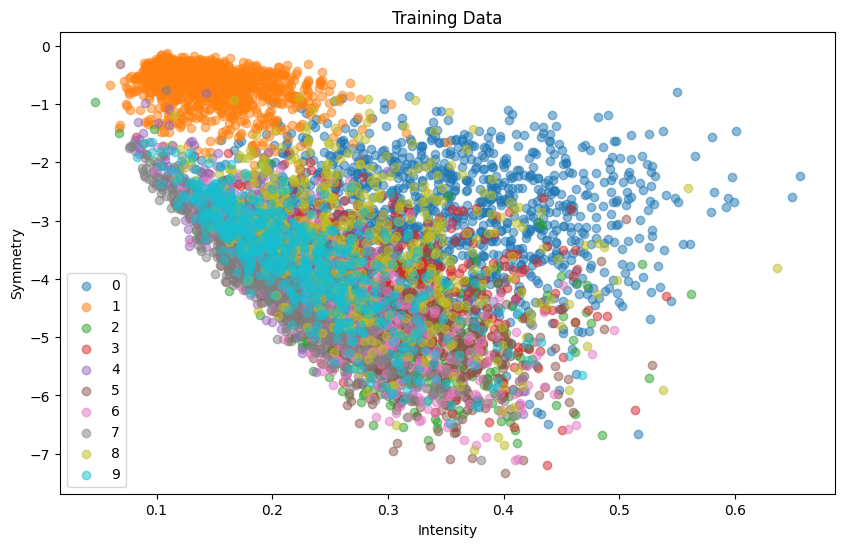

In [4]:
plt.figure(figsize=(10, 6))
for digit in np.unique(y_train):
    mask = y_train == digit
    plt.scatter(X_train[mask, 0], X_train[mask, 1], label=str(digit), marker='o', alpha=0.5)

plt.title("Training Data")
plt.xlabel("Intensity")
plt.ylabel("Symmetry")
plt.legend()
plt.show()

##Step 2 train and evaluate a binary classifier

In [5]:
def train_binary_classifier(X, y, X_test, y_test, digit1, digit2, kernel='linear', C=1.0, degree=3):
    # Extract binary labels
    binary_mask = np.logical_or(y == digit1, y == digit2)
    y_binary = np.where(y[binary_mask] == digit1, 1, -1)
    X_binary = X[binary_mask]

    # One-vs-one
    svm_clf = SVC(kernel=kernel, C=C, degree=degree, gamma='auto')
    svm_clf.fit(X_binary, y_binary)

    # Evaluate on training data
    y_pred_train = svm_clf.predict(X_binary)
    train_error = 1 - accuracy_score(y_binary, y_pred_train)

    # Evaluate on test data
    y_pred_test = svm_clf.predict(X_test)
    test_error = 1 - accuracy_score(np.where(y_test == digit1, 1, np.where(y_test == digit2, -1, 0)), y_pred_test)

    return svm_clf, train_error, test_error

Classifier with highest E_train: (4, 7)
Classifier with lowest E_train: (1, 5)
Closest value to the difference between support vectors: 1200


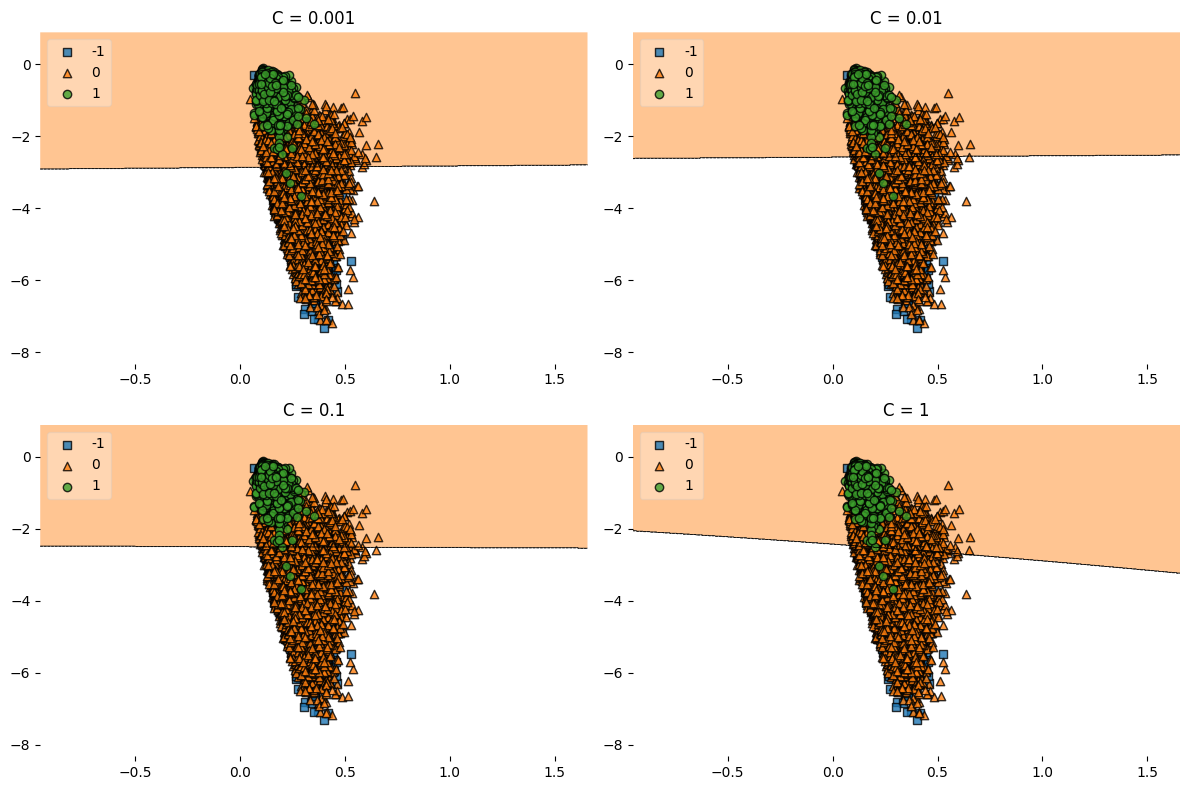

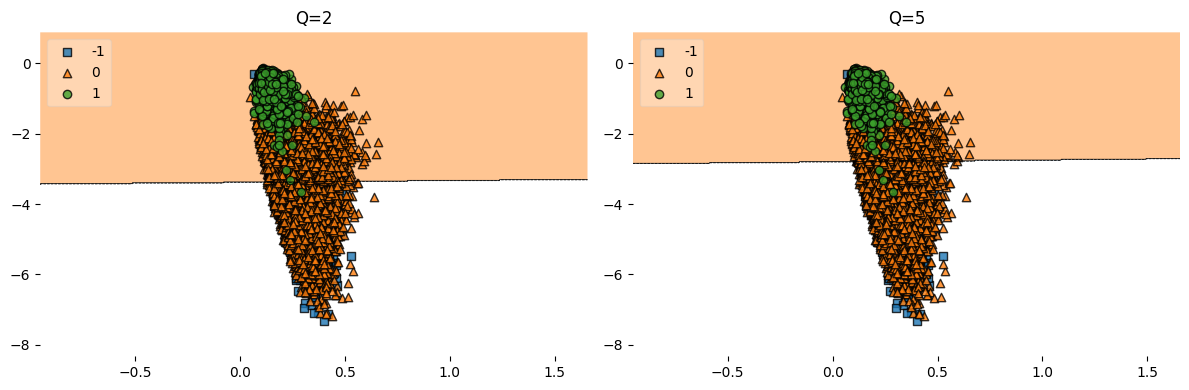

In [6]:
from mlxtend.plotting import plot_decision_regions

# Problem 1 - With C=0.01 and Q=2, which classifier has the highest E_train?
highest_train_error = 0
highest_train_error_digit = None
for digit1, digit2 in itertools.combinations(range(10), 2):
    svm_clf, train_error, _ = train_binary_classifier(X_train, y_train, X_test, y_test,
                                                      digit1, digit2, kernel='poly', C=0.01, degree=2)
    if train_error > highest_train_error:
        highest_train_error = train_error
        highest_train_error_digit = (digit1, digit2)

print(f"Classifier with highest E_train: {highest_train_error_digit}")

# Problem 2: With C=0.01 and Q=2, which classifier has the lowest E_train?
lowest_train_error = 1
lowest_train_error_digit = None
for digit1, digit2 in itertools.combinations(range(10), 2):
    svm_clf, train_error, _ = train_binary_classifier(X_train, y_train, X_test, y_test,
                                                      digit1, digit2, kernel='poly', C=0.01, degree=2)
    if train_error < lowest_train_error:
        lowest_train_error = train_error
        lowest_train_error_digit = (digit1, digit2)

print(f"Classifier with lowest E_train: {lowest_train_error_digit}")

# Problem 3: Comparing the two selected classifiers from Problems 1 and 2, which of the following values is the closest to the difference between the number of support vectors of these two classifiers?
clf1, _, _ = train_binary_classifier(X_train, y_train, X_test, y_test,
                                     highest_train_error_digit[0], highest_train_error_digit[1],
                                     kernel='poly', C=0.01, degree=2)
clf2, _, _ = train_binary_classifier(X_train, y_train, X_test, y_test,
                                     lowest_train_error_digit[0], lowest_train_error_digit[1],
                                     kernel='poly', C=0.01, degree=2)

support_vector_diff = abs(len(clf1.support_vectors_) - len(clf2.support_vectors_))
closest_choice = min([(600, abs(600 - support_vector_diff)), (1200, abs(1200 - support_vector_diff)),
                      (1800, abs(1800 - support_vector_diff)), (2400, abs(2400 - support_vector_diff)),
                      (3000, abs(3000 - support_vector_diff))], key=lambda x: x[1])[0]

print(f"Closest value to the difference between support vectors: {closest_choice}")

# Problem 4: Consider the 1 versus 5 classifier with Q=2 and C ∈ {0.001, 0.01, 0.1, 1}. Which of the following statements is correct?

#C_values = [0.001, 0.01, 0.1, 1]
#for C in C_values:
#    svm_clf, train_error, test_error = train_binary_classifier(X_train, y_train, X_test, y_test,
#                                                               1, 5, kernel='poly', C=C, degree=2)
#    print(f"C = {C}, Number of support vectors: {len(svm_clf.support_vectors_)}, E_train: {train_error}, E_test: {test_error}")

C_values = [0.001, 0.01, 0.1, 1]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, C in zip(axes, C_values):
    svm_clf, _, _ = train_binary_classifier(X_train, y_train, X_test, y_test, 1, 5, kernel='poly', C=C, degree=2)
    plot_decision_regions(X=X_train, y=np.where(y_train == 1, 1, np.where(y_train == 5, -1, 0)),
                          clf=svm_clf, legend=2, ax=ax)
    ax.set_title(f"C = {C}")

plt.tight_layout()
plt.show()

# Problem 5: In the 1 versus 5 classifier, comparing Q=2 with Q=5, which of the following statements is correct?
#svm_clf_Q2, train_error_Q2, test_error_Q2 = train_binary_classifier(X_train, y_train, X_test, y_test,
#                                                                    1, 5, kernel='poly', C=0.0001, degree=2)
#svm_clf_Q5, train_error_Q5, test_error_Q5 = train_binary_classifier(X_train, y_train, X_test, y_test,
#                                                                    1, 5, kernel='poly', C=0.0001, degree=5)

#print(f"C=0.0001, Q=2: E_train={train_error_Q2}, Q=5: E_train={train_error_Q5}")
#print(f"C=0.0001, Q=2: Number of support vectors={len(svm_clf_Q2.support_vectors_)}, Q=5: Number of support vectors={len(svm_clf_Q5.support_vectors_)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

svm_clf_Q2, _, _ = train_binary_classifier(X_train, y_train, X_test, y_test, 1, 5, kernel='poly', C=0.0001, degree=2)
plot_decision_regions(X=X_train, y=np.where(y_train == 1, 1, np.where(y_train == 5, -1, 0)),
                      clf=svm_clf_Q2, legend=2, ax=axes[0])
axes[0].set_title("Q=2")

svm_clf_Q5, _, _ = train_binary_classifier(X_train, y_train, X_test, y_test, 1, 5, kernel='poly', C=0.0001, degree=5)
plot_decision_regions(X=X_train, y=np.where(y_train == 1, 1, np.where(y_train == 5, -1, 0)),
                      clf=svm_clf_Q5, legend=2, ax=axes[1])
axes[1].set_title("Q=5")

plt.tight_layout()
plt.show()

# Repeat for other C values (0.001, 0.01, 1)

## Cross Validation
In the next two problems, we will experiment with 10 -fold cross validation for the polynomial kernel. Because $E_{c v}$ is a random variable that depends on the random partition of the data, we will try 100 runs with different partitions and base our answer on how many runs lead to a particular choice.

Consider the 1 versus 5 classifier with $Q=2$. We use $E_{c v}$ to select $C \in\{0.0001,0.001,0.01,0.1,1\}$. If there is a tie in $E_{c v}$, select the smaller $C$. Within the 100 random runs, which of the following statements is correct?


(a) $C=0.0001$ is selected most often.

(b) $C=0.001$ is selected most often.

(c) $C=0.01$ is selected most often.

(d) $C=0.1$ is selected most often.

(e) $C=1$ is selected most often.

***Answer: b***


Again, consider the 1 versus 5 classifier with $Q=2$. For the winning selection in the previous problem, the average value of $E_{c v}$ over the 100 runs is closest to


(a) 0.001

(b) 0.003

(c) 0.005

(d) 0.007

(e) 0.009

***Answer: c***

*Code below:*

In [7]:
def train_binary_classifier_cv(X, y, digit1, digit2, kernel='linear', C=1.0, degree=3, n_splits=10, n_runs=100):
    # Extract binary labels
    binary_mask = np.logical_or(y == digit1, y == digit2)
    y_binary = np.where(y[binary_mask] == digit1, 1, -1)
    X_binary = X[binary_mask]

    cv_errors = []
    for _ in range(n_runs):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_scores = []
        for train_index, val_index in kf.split(X_binary):
            X_train, X_val = X_binary[train_index], X_binary[val_index]
            y_train, y_val = y_binary[train_index], y_binary[val_index]

            # Train SVM
            svm_clf = SVC(kernel=kernel, C=C, degree=degree, gamma='auto')
            svm_clf.fit(X_train, y_train)

            # Evaluate on validation data
            y_pred_val = svm_clf.predict(X_val)
            val_error = 1 - accuracy_score(y_val, y_pred_val)
            cv_scores.append(val_error)

        cv_error = np.mean(cv_scores)
        cv_errors.append(cv_error)

    return np.mean(cv_errors)

In [8]:
# Problem 6: Consider the 1 versus 5 classifier with Q=2. We use E_cv to select C ∈ {0.0001, 0.001, 0.01, 0.1, 1}. If there is a tie in E_cv, select the smaller C. Within the 100 random runs, which of the following statements is correct?
C_values = [0.0001, 0.001, 0.01, 0.1, 1]
cv_errors = []
for C in C_values:
    cv_error = train_binary_classifier_cv(X_train, y_train, 1, 5, kernel='poly', C=C, degree=2, n_splits=10, n_runs=100)
    cv_errors.append(cv_error)

best_C = C_values[np.argmin(cv_errors)]
print(f"The most frequently selected C value is: {best_C}")

# Problem 7: Again, consider the 1 versus 5 classifier with Q=2. For the winning selection in the previous problem, the average value of E_cv over the 100 runs is closest to
best_cv_error = cv_errors[np.argmin(cv_errors)]
closest_choice = min([(0.001, abs(0.001 - best_cv_error)), (0.003, abs(0.003 - best_cv_error)),
                      (0.005, abs(0.005 - best_cv_error)), (0.007, abs(0.007 - best_cv_error)),
                      (0.009, abs(0.009 - best_cv_error))], key=lambda x: x[1])[0]

print(f"The average value of E_cv over the 100 runs is closest to: {closest_choice}")

The most frequently selected C value is: 0.01
The average value of E_cv over the 100 runs is closest to: 0.005


## RBF Kernel
Consider the radial basis function (RBF) kernel $K\left(\boldsymbol{x}_{n}, \boldsymbol{x}_{m}\right)=\exp \left(-\left\|\boldsymbol{x}_{n}-\boldsymbol{x}_{m}\right\|^{2}\right)$ in the soft-margin SVM approach. Focus on the 1 versus 5 classifier.

Which of the following values of $C$ results in the lowest $E_{\text {train }}$ ?

(a) $C=0.01$

(b) $C=1$

(c) $C=100$

(d) $C=10^{4}$

(e) $C=10^{6}$

***Answer: e***

Which of the following values of $C$ results in the lowest $E_{\text {test }}$ ?


(a) $C=0.01$

(b) $C=1$

(c) $C=100$

(d) $C=10^{4}$

(e) $C=10^{6}$

***Answer: c***

*Code below:*

In [9]:
def train_binary_classifier_rbf(X, y, X_test, y_test, digit1, digit2, C):
    # Extract binary labels
    binary_mask = np.logical_or(y == digit1, y == digit2)
    y_binary = np.where(y[binary_mask] == digit1, 1, -1)
    X_binary = X[binary_mask]

    # Train SVM with RBF kernel
    svm_clf = SVC(kernel='rbf', C=C, gamma='auto')
    svm_clf.fit(X_binary, y_binary)

    # Evaluate on training data
    y_pred_train = svm_clf.predict(X_binary)
    train_error = 1 - accuracy_score(y_binary, y_pred_train)

    # Evaluate on test data
    y_pred_test = svm_clf.predict(X_test)
    test_error = 1 - accuracy_score(np.where(y_test == digit1, 1, np.where(y_test == digit2, -1, 0)), y_pred_test)

    return svm_clf, train_error, test_error

The value of C that results in the lowest E_train is: 1000000


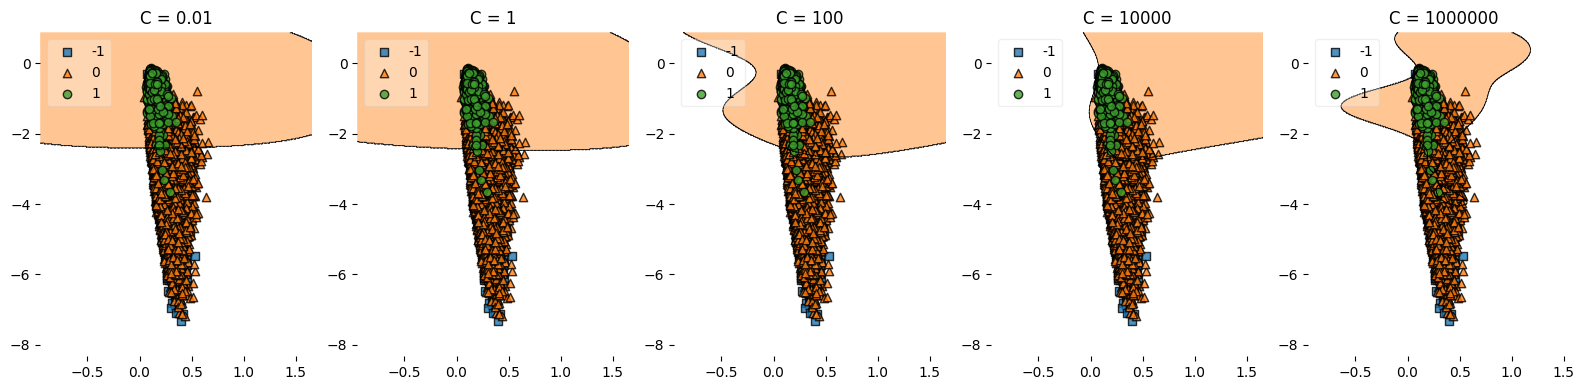

The value of C that results in the lowest E_test is: 100


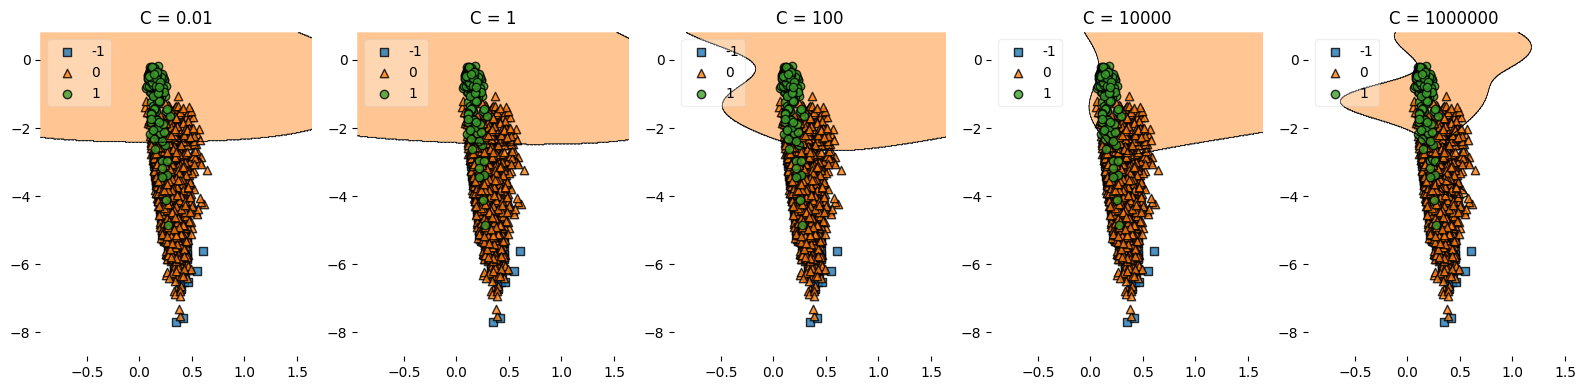

In [10]:
# Problem 7: Which of the following values of C results in the lowest E_train?
C_values = [0.01, 1, 100, 10000, 1000000]
lowest_train_error = 1
best_C_train = None

train_errors = []
train_classifiers = []

for C in C_values:
    svm_clf, train_error, _ = train_binary_classifier_rbf(X_train, y_train, X_test, y_test, 1, 5, C)
    train_errors.append(train_error)
    train_classifiers.append(svm_clf)
    if train_error < lowest_train_error:
        lowest_train_error = train_error
        best_C_train = C

print(f"The value of C that results in the lowest E_train is: {best_C_train}")
# Plot decision boundaries for different C values
fig, axes = plt.subplots(1, len(C_values), figsize=(16, 4))

for ax, C, svm_clf in zip(axes, C_values, train_classifiers):
    plot_decision_regions(X=X_train, y=np.where(y_train == 1, 1, np.where(y_train == 5, -1, 0)),
                          clf=svm_clf, legend=2, ax=ax)
    ax.set_title(f"C = {C}")

plt.tight_layout()
plt.show()
# Problem 8: Which of the following values of C results in the lowest E_test?
lowest_test_error = 1
best_C_test = None

test_errors = []
test_classifiers = []

for C in C_values:
    svm_clf, _, test_error = train_binary_classifier_rbf(X_train, y_train, X_test, y_test, 1, 5, C)
    test_errors.append(test_error)
    test_classifiers.append(svm_clf)
    if test_error < lowest_test_error:
        lowest_test_error = test_error
        best_C_test = C

print(f"The value of C that results in the lowest E_test is: {best_C_test}")

# Plot decision boundaries for different C values
fig, axes = plt.subplots(1, len(C_values), figsize=(16, 4))

for ax, C, svm_clf in zip(axes, C_values, test_classifiers):
    plot_decision_regions(X=X_test, y=np.where(y_test == 1, 1, np.where(y_test == 5, -1, 0)),
                          clf=svm_clf, legend=2, ax=ax)
    ax.set_title(f"C = {C}")

plt.tight_layout()
plt.show()